In [4]:
%load_ext zipline
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [6]:

from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
from matplotlib import pyplot as plt
import pandas as pd

def initialize(context):
    # Securities and target weights
    context.securities = {
        'NTAR': 0.25, 
        'PKK': 0.25, 
        'IDK': 0.25, 
        'VSBY': 0.125, 
        'VST': 0.125
    }
    
    # Schedule rebalance for once a month
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())
    
def rebalance(context, data):
    # Loop through the securities
    for sec, weight in context.securities.items():
        sym = symbol(sec)
        # Check if we can trade
        if data.can_trade(sym):
            # Reset the weight
            order_target_percent(sym, weight) 
            
# Set start and end
start = pd.Timestamp('2019-06-01', tz='utc')
end = pd.Timestamp('2020-11-27', tz='utc')
# Fire off backtest
result = run_algorithm(
    start=start, 
    end=end, 
    initialize=initialize,  
    capital_base=10000, 
    bundle='bt_tickers' 
)

print("Ready to analyze result.")

Ready to analyze result.


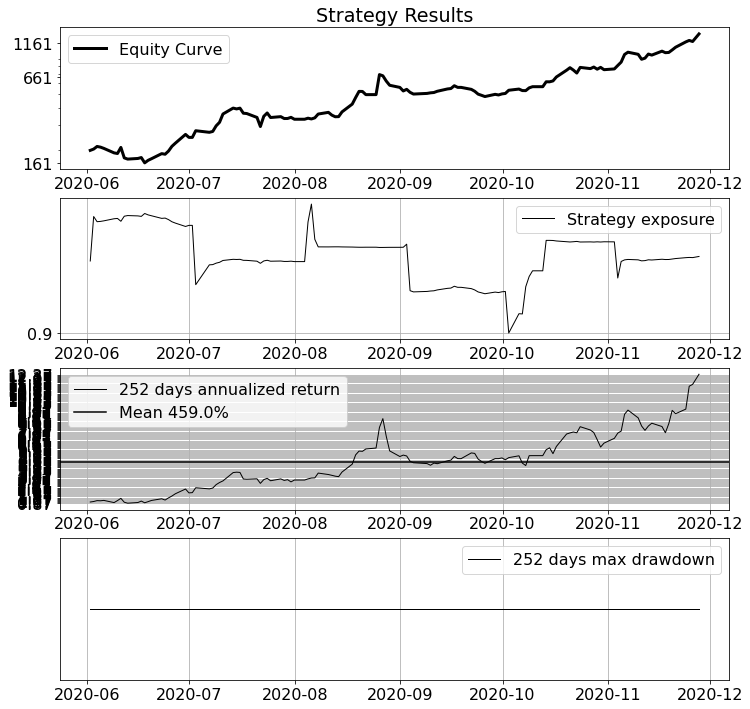

In [8]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, ticker, rc

# Format for book image
font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}
rc('font', **font)

# Settings
window = 252
year_length = 252

# Copy the columsn we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = result.portfolio_value.rolling(window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.2 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)
ax.axhline(df['annualized'].mean(), color='black', linewidth=1.5, label='Mean {:0.1f}%'.format(df['annualized'].mean() * 100))

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)